In [153]:
import json, jsonschema
import time
import tqdm
import numpy as np
import openai
import asyncio
from ragatouille import RAGPretrainedModel
import materialized_intelligence as mi
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from cards import CardDataset

In [3]:
cards = CardDataset.from_file("oracle-cards-20250405210637.json")

INFO 2025-05-02 14:57:36 [cards:22] Double-faced cards not yet supported, omitting.
INFO 2025-05-02 14:57:37 [cards:132] Imported 30497 of 34458 cards from oracle-cards-20250405210637.json


In [4]:
all_queries = {}
with open("synthetic_queries.json", "r") as f:
    all_queries = json.load(f)
print(f"Loaded {len(all_queries)} queries")

Loaded 30497 queries


In [22]:
# num_samples = 10
# np.random.seed(0)
# sampled_card_names = np.random.choice(cards.card_names, num_samples, replace=False)
sampled_card_names = list(all_queries.keys())

query_pairs = []
for card_name in sampled_card_names:
    for query in all_queries[card_name]:
        query_pairs.append((card_name, query))

print(f"Sampled {len(query_pairs)} queries for {len(sampled_card_names)} cards")

Sampled 296527 queries for 30497 cards


In [6]:
RAG = RAGPretrainedModel.from_index(".ragatouille/colbert/indexes/mtg_cards")
_ = RAG.search("magic card", k=100)

/home/benchislett/Repos/Hexanomicon/.venv/lib/python3.12/site-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Loading searcher for index mtg_cards for the first time... This may take a few seconds
[May 02, 14:57:43] #> Loading codec...
[May 02, 14:57:43] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/home/benchislett/Repos/Hexanomicon/.venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[May 02, 14:57:43] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/home/benchislett/Repos/Hexanomicon/.venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[May 02, 14:57:43] #> Loading IVF...
[May 02, 14:57:43] #> Loading doclens...


100%|██████████| 2/2 [00:00<00:00, 4877.10it/s]


[May 02, 14:57:43] #> Loading codes and residuals...


100%|██████████| 2/2 [00:00<00:00, 65.07it/s]


Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: magic card, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 3894, 4003,  102,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



/home/benchislett/Repos/Hexanomicon/.venv/lib/python3.12/site-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


In [32]:
negatives_for_queries = []
maybenegatives_for_queries = []
all_rag_results = RAG.search([query for _, query in query_pairs], k=20)
for idx, (card_name, query) in enumerate(tqdm.tqdm(query_pairs)):
    results = all_rag_results[idx]
    results_thecard = [r for r in results if r['document_id'] == card_name]
    # sample 10 from the topk==20
    results = np.random.choice(results, 10, replace=False)
    results_negatives = []
    results_maybenegatives = []
    if len(results_thecard) == 0:
        # Card not found in the topk
        # Keep all of the topk as negative examples
        results_negatives = [r["document_id"] for r in results]
    else:
        # Card found in the topk
        # Need to check the rest of the topk to be sure they are negative
        results_maybenegatives = [r["document_id"] for r in results if r['document_id'] != card_name]
    negatives_for_queries.append(results_negatives)
    maybenegatives_for_queries.append(results_maybenegatives)

/home/benchislett/Repos/Hexanomicon/.venv/lib/python3.12/site-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
273914it [25:43, 177.50it/s]


KeyboardInterrupt: 

In [50]:
sum(len(i) for i in negatives_for_queries), sum(len(i) for i in maybenegatives_for_queries), len([i for i in negatives_for_queries if i]), len([i for i in maybenegatives_for_queries if i])

(7077200, 7594167, 141544, 154983)

In [13]:
negative_classification_sys_prompt = """You are an expert AI assisting in creating a high-quality, diverse synthetic dataset to train Information Retrieval systems for Magic: The Gathering cards.
Your task is to classify a set of potential matches for a given query as either positive or negative examples. Negative examples are cards that are not relevant to the query.
The set of potential matches has been generated by a search engine and may contain both relevant, and irrelevant cards.
The purpose of this task is to identify cards that are not relevant to the query, but may be similar in some way to the true matches being queried, and mark those as negatives.
Quality of the negative examples is most important, and false negatives should be avoided.

Your output should be a JSON object with keys as the card names and values as either "positive" or "negative" for each card provided in the input.
Do not include any other response or text in your output.
For example:
<example_output>
```json
{
    "Card Name 1": "positive",
    "Card Name 2": "negative",
    "Card Name 3": "negative"
}
```
</example_output>
""".strip()

def prepare_negative_classification_prompt(query: str, formatted_positive: str, formatted_negatives: list[str]) -> str:
    prompt = f"""The user query is the following:
<query>
{query}
</query>

The following card is a confirmed true positive match for the query:
<confirmed_positive>
{formatted_positive}
</confirmed_positive>

The input cards are as follows:
<input>
""".strip()
    for card in formatted_negatives:
        prompt += f"{card}\n<input_separator/>\n"
    prompt = prompt.strip("<input_separator/>\n")
    prompt += "</input>"
    return prompt.strip()

In [ ]:
# Show an example prompt
card_name, query = query_pairs[0]
potential_negatives = maybenegatives_for_queries[0]
sample_prompt = prepare_negative_classification_prompt(
    query=query,
    formatted_positive=cards.formatted_cards[card_name],
    formatted_negatives=[cards.formatted_cards[card_name] for card_name in potential_negatives]
)
# print(sample_prompt)

In [52]:
maybenegatives_for_queries[0]

['Grazing Gladehart',
 'Sporemound',
 'Architect of the Untamed',
 'Strider, Ranger of the North',
 'Tato Farmer',
 'Baloth Woodcrasher',
 'Elfsworn Giant',
 'Snapping Creeper',
 'Nissa, Resurgent Animist',
 'Avenger of Zendikar']

In [53]:
all_prompts = []
for i in range(len(query_pairs)):
    card_name, query = query_pairs[i]
    potential_negatives = maybenegatives_for_queries[i]
    all_prompts.append(prepare_negative_classification_prompt(
        query=query,
        formatted_positive=cards.formatted_cards[card_name],
        formatted_negatives=[cards.formatted_cards[str(n)] for n in potential_negatives]
    ))
print(f"Prepared {len(all_prompts)} prompts for negative classification")

Prepared 296527 prompts for negative classification


In [65]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.3-70B-Instruct")

num_subset = 1000000000
sys_prompt_num_tokens = len(tokenizer(negative_classification_sys_prompt)["input_ids"])
all_tokenized_results = tokenizer(all_prompts[0:num_subset], return_length=True, add_special_tokens=True, padding=False, truncation=False)
num_total_tokens = sum(all_tokenized_results["length"])
print(num_total_tokens, sys_prompt_num_tokens, num_total_tokens + len(all_prompts[0:num_subset]) * sys_prompt_num_tokens)

192398748 229 260303431


In [76]:
print(all_prompts[-1])

The user query is the following:
<query>
red sorcery with escalating effects on consecutive coin flips
</query>

The following card is a confirmed true positive match for the query:
<confirmed_positive>
Fiery Gambit
Sorcery
Colors: Red
Mana cost: {2}{R}
Converted mana cost: 3.0
Oracle text: Flip a coin until you lose a flip or choose to stop flipping. If you lose a flip, Fiery Gambit has no effect. If you win one or more flips, Fiery Gambit deals 3 damage to target creature. If you win two or more flips, Fiery Gambit deals 6 damage to each opponent. If you win three or more flips, draw nine cards and untap all lands you control.
</confirmed_positive>

The input cards are as follows:
<input>Impulsive Maneuvers
Enchantment
Colors: Red
Mana cost: {2}{R}{R}
Converted mana cost: 4.0
Oracle text: Whenever a creature attacks, flip a coin. If you win the flip, the next time that creature would deal combat damage this turn, it deals double that damage instead. If you lose the flip, the next tim

In [58]:
results

{'lower_cost_estimate': 42.3891221616, 'upper_cost_estimate': 84.7782443232}

In [ ]:
job_id = mi.infer(all_prompts, system_prompt=negative_classification_sys_prompt, model="llama-3.3-70b-64k", job_priority=1)

In [ ]:
results = mi.get_job_results(job_id)
print(results[0])

In [147]:
def postprocess_negative_classification_response(model_output: str) -> list[str]:
    try:
        model_output = model_output.strip()
        if '```' in model_output:
            idx_start = model_output.index("```") + len("```")
            idx_end = model_output.index("```", idx_start) if "```" in model_output[idx_start:] else len(model_output)
            model_output = model_output[idx_start:idx_end].strip().strip('json').strip()
        # idx_start = model_output.index("```json") + len("```json")
        # idx_end = model_output.index("```", idx_start) if "```" in model_output[idx_start:] else len(model_output)
        # model_output = model_output[idx_start:idx_end].strip()
        data = json.loads(model_output)
        positives = []
        negatives = []
        for k in data:
            if data[k].lower() == "positive":
                positives.append(k)
            elif data[k].lower() == "negative":
                negatives.append(k)
        return positives, negatives
    except json.JSONDecodeError as e:
        # print(f"Failed to parse JSON: {e}")
        return [], []
    except jsonschema.ValidationError as e:
        # print(f"Validation error: {e}")
        return [], []

In [148]:
positives, negatives = zip(*[postprocess_negative_classification_response(x) for x in results])
positives = list(positives)
negatives = list(negatives)
for i in range(len(maybenegatives_for_queries)):
    card_name, query = query_pairs[i]
    candidates = maybenegatives_for_queries[i]
    if len(candidates) == 0:
        negatives[i] = []
        positives[i] = []
    else:
        candidates_lower = [x.lower() for x in candidates]
        positives[i] = [x for x in positives[i] if x.lower() in candidates_lower]
        negatives[i] = [x for x in negatives[i] if x.lower() in candidates_lower]
num_failures = sum([1 for i in range(len(positives)) if (len(positives[i]) == 0 and len(negatives[i]) == 0)])
print(f"Got {num_failures} failures out of {len(positives)} queries")
print(f"Got {len(positives)} positive arrays and {len(negatives)} negative arrays")
print(f"Got {sum([len(i) for i in positives if i])} positive matches and {sum([len(i) for i in negatives if i])} negative matches")

Got 141548 failures out of 296527 queries
Got 296527 positive arrays and 296527 negative arrays
Got 418204 positive matches and 1130229 negative matches


In [149]:
len(list(filter(lambda x: len(x) == 0, positives)))

181550

In [150]:
len(list(filter(lambda x: len(x) == 0, maybenegatives_for_queries)))

141544

In [151]:
negatives_for_queries

[[],
 [],
 [],
 ['Stone Idol Generator',
  'Ornery Tumblewagg',
  'Synth Eradicator',
  'T-45 Power Armor',
  'Yorvo, Lord of Garenbrig',
  'Smelted Chargebug',
  'Mountain Titan',
  'Serpent Generator',
  'Energy Vortex',
  'Aether Spike',
  'Peema Trailblazer',
  'Ursine Fylgja',
  'Ulamog, the Defiler',
  'Izzet Generatorium',
  'Ichor Synthesizer',
  'Glyph Elemental',
  'Cragsmasher Yeti',
  'Bristling Hydra',
  "Atraxa's Skitterfang",
  'Assaultron Dominator',
  'Blaster Hulk',
  'Peema Aether-Seer',
  'There and Back Again',
  'Duskfang Mentor',
  'Electrosiphon',
  'Nyxborn Hydra',
  'Grumgully, the Generous',
  'Gwyllion Hedge-Mage',
  'Garenbrig Paladin',
  'Dimir Spybug',
  'Fabrication Module',
  'Fylgja',
  'Purraj of Urborg',
  'Hierophant Bio-Titan',
  'Aetherstorm Roc',
  'Phyrexian Ironworks',
  'Highspire Infusion',
  'Wolverine, Best There Is',
  'Razorfield Ripper',
  'Emissary of Soulfire',
  'Thriving Ibex',
  'Skyshroud Ridgeback',
  'Bulwark Ox',
  'Lily Bowen, 

In [200]:
final_mined_negatives = []
all_card_names = set(cards.card_names)
for i in tqdm.tqdm(range(len(query_pairs))):
    card_name, query = query_pairs[i]
    negative_values = []
    if len(negatives_for_queries[i]) != 0:
        negative_values = negatives_for_queries[i]
    elif len(negatives[i]) != 0:
        negative_values = negatives[i]
    len_before = len(negative_values)
    negative_values = [x for x in negative_values if x in all_card_names]
    len_after = len(negative_values)
    if len_after == 0 and len_before != 0:
        raise
    final_mined_negatives.append((card_name, query, negative_values))

100%|██████████| 296527/296527 [00:00<00:00, 304731.26it/s]


In [207]:
medium_negatives = {}
with open("medium_negatives.jsonl", "r") as f:
    for line in f:
        data = json.loads(line)
        medium_negatives[data["card_name"]] = data["negatives"]
print(f"Loaded {len(medium_negatives)} medium negatives")

all_card_names = set(cards.card_names)

train_triples_data = []
for i in tqdm.tqdm(range(len(query_pairs))):
    card_name, query = query_pairs[i]
    doc_positive = cards.formatted_cards[card_name]
    doc_id_positive = card_name
    doc_negatives = []
    doc_id_negatives = []
    # want 20 negatives per query:
    # if we have >= 15 hard mined negatives, sample 15 from those and use 5 from the medium negatives for the card
    # if we have < 15 hard mined negatives, use all of those and sample the rest from the medium negatives
    if card_name not in medium_negatives:
        continue
    medium_negatives_for_card = medium_negatives[card_name]
    medium_negatives_for_card = [x for x in medium_negatives_for_card if x in all_card_names]
    if len(final_mined_negatives[i][2]) >= 15:
        doc_id_negatives = np.random.choice(final_mined_negatives[i][2], 15, replace=False).tolist()
        sampled_medium_negatives = np.random.choice(medium_negatives_for_card, 5, replace=False).tolist()
        doc_id_negatives += sampled_medium_negatives
    else:
        doc_id_negatives = final_mined_negatives[i][2]
        num_needed = 20 - len(doc_id_negatives)
        sampled_medium_negatives = np.random.choice(medium_negatives_for_card, num_needed, replace=False).tolist()
        doc_id_negatives += sampled_medium_negatives
    doc_negatives = [cards.formatted_cards[x] for x in doc_id_negatives]
    for j in range(len(doc_negatives)):
        train_triples_data.append({
            "query": query,
            "doc_id_positive": doc_id_positive,
            "doc_positive": doc_positive,
            "doc_id_negative": doc_id_negatives[j],
            "doc_negative": doc_negatives[j]
        })

# add the data to the dataframe
train_triples_df = pd.DataFrame(train_triples_data)
train_triples_df.to_parquet("train_triples_20x_hard_and_medium.parquet", compression='gzip', index=False)

Loaded 31095 medium negatives


100%|██████████| 296527/296527 [00:07<00:00, 37565.52it/s]


In [204]:
query_cards_ = set([i for i, _ in query_pairs])
negative_cards_ = set([i for i in medium_negatives.keys()])
len(query_cards_), len(negative_cards_)

(30497, 31095)

In [206]:
query_cards_ - negative_cards_

{'Detective',
 'Drowned',
 'Eldrazi',
 'Grave Robbers',
 'Multi-Headed',
 'Phyrexian',
 'Unquenchable Fury'}

In [192]:
final_mined_negatives[i][2]

['Agonizing Demise',
 'Kill! Destroy!',
 'Caught in the Crossfire',
 'Victim of Night',
 'Saw in Half',
 'Murderous Spoils',
 'Dead Before Sunrise',
 'Capital Offense',
 'Broken Visage',
 "Eyeblight's Ending",
 'Extinguish All Hope',
 'Eliminate',
 "In Garruk's Wake",
 'Asphyxiate',
 'Defenestrate',
 'Slaughter Cry',
 'Vanquish the Weak',
 'Cast Down',
 'Cut Down',
 'Topple']

In [184]:
final_mined_negatives[i][2]

['Impulsive Maneuvers',
 'Polis the Planeshifter',
 'Molten Birth',
 'Winter Sky',
 'Goblin Bomb',
 'Strategy, Schmategy',
 'Stitch in Time',
 "Squee's Revenge",
 'Karplusan Minotaur']

In [170]:
len(final_mined_negatives)

296527

In [164]:
len(set([card_name for card_name, query in query_pairs]))

30497

In [168]:
sum([1 for i in final_mined_negatives if len(i[2]) == 0])

2932

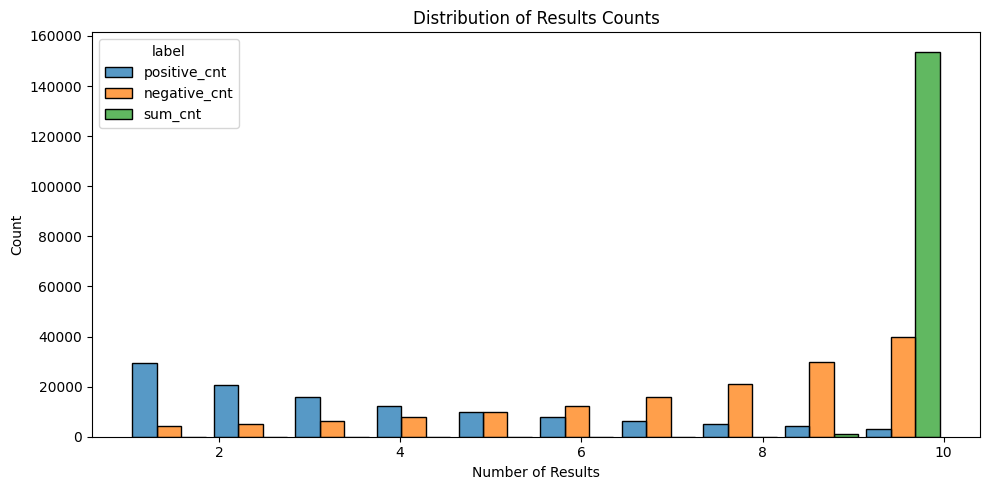

In [ ]:
# show a histogram using seaborn of the number of positives and negatives
num_positives = [len(i) for i in positives]
num_negatives = [len(i) for i in negatives]

df = pd.DataFrame({
    "positive_cnt": num_positives,
    "negative_cnt": num_negatives,
    "sum_cnt": [len(a) + len(b) for a, b in zip(positives, negatives)],
})

long_df = (
    df.melt(value_vars=["positive_cnt", "negative_cnt", "sum_cnt"],
            var_name="label",
            value_name="count")
      .query("count > 0")
)

# --- plot with a bit of spacing ---
plt.figure(figsize=(10, 5))
sns.histplot(
    data=long_df,
    x="count",
    hue="label",
    multiple="dodge",
    bins=10,
    shrink=0.9,
    stat="count",
)

plt.title("Distribution of Results Counts")
plt.xlabel("Number of Results")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [143]:
min([len(a) + len(b) for a, b in zip(positives, negatives) if (len(a) + len(b)) > 0])

2

In [120]:
[idx for idx, i in enumerate(negatives) if len(i) > 100]

[]

In [108]:
sum(1 for i in maybenegatives_for_queries if len(i) == 0)

141544

In [74]:
print(all_prompts[0])

The user query is the following:
<query>
Green landfall cards that generate energy
</query>

The following card is a confirmed true positive match for the query:
<confirmed_positive>
Nissa, Worldsoul Speaker
Legendary Creature — Elf Druid
Colors: Green
Mana cost: {3}{G}
Converted mana cost: 4.0
Power/Toughness: 3/3
Keywords: Landfall
Oracle text: Landfall — Whenever a land you control enters, you get {E}{E} (two energy counters).
You may pay eight {E} rather than pay the mana cost for permanent spells you cast.
</confirmed_positive>

The input cards are as follows:
<input>Grazing Gladehart
Creature — Antelope
Colors: Green
Mana cost: {2}{G}
Converted mana cost: 3.0
Power/Toughness: 2/2
Keywords: Landfall
Oracle text: Landfall — Whenever a land you control enters, you may gain 2 life.
<input_separator/>
Sporemound
Creature — Fungus
Colors: Green
Mana cost: {3}{G}{G}
Converted mana cost: 5.0
Power/Toughness: 3/3
Keywords: Landfall
Oracle text: Landfall — Whenever a land you control enter

In [28]:
for i in positives:
    assert i in potential_negatives, f"Positive {i} not in potential negatives"
for i in negatives:
    assert i in potential_negatives, f"Negative {i} not in potential negatives"

In [22]:
print(cards.formatted_cards[positives[0]])

Unlicensed Disintegration
Instant
Colors: Black, Red
Mana cost: {1}{B}{R}
Converted mana cost: 3.0
Oracle text: Destroy target creature. If you control an artifact, Unlicensed Disintegration deals 3 damage to that creature's controller.


In [42]:
sum(len(i[1]) for i in all_queries.items())

296527

In [40]:
len(query_pairs)

98

In [44]:
296_527 * 0.5 * 5_000

741317500.0

In [ ]:
741_317_500

In [ ]:
10_000_000

In [49]:
31_000 * 5_000 // 2

77500000

In [52]:
len(negatives_for_queries)

296527

In [53]:
len(query_pairs)

296527

In [54]:
with open("negative_candidates_colbertv2-base.json", "w") as f:
    obj = {
        "query_pairs": query_pairs,
        "negatives_for_queries": negatives_for_queries,
        "maybenegatives_for_queries": maybenegatives_for_queries,
    }
    f.write(json.dumps(obj, indent=2))

In [137]:
# Since there are so many queries, we should prune them to just two per card
# This will be done using Llama 8B and materialized intelligence API

query_pruning_sys_prompt = """You are an expert AI assisting in creating a high-quality, diverse synthetic dataset to train Information Retrieval systems for Magic: The Gathering cards.
Your task is to prune a set of queries for a given card to only the most relevant ones. The set of queries has been generated by a very large language model and should all be relevant to the card.
For cost reasons, we want to prune the queries to only the most relevant ones, while aiming to maintain a diverse set of queries.

Your input will be a Magic: The Gathering card description document, and a set of up to 10 queries for that card.
Your output should be a JSON list with the two most relevant queries for the card. Do not include any other text in your response, before or after the JSON list.
Here is the output format in JSON schema:
<schema>
{
    "type": "array",
    "items": {
        "type": "string"
    },
    "maxItems": 2,
    "minItems": 2,
    "uniqueItems": true
}
</schema>
"""

query_pruning_schema = {
    "type": "array",
    "items": {
        "type": "string"
    },
}

def prepare_query_pruning_prompt(card_description: str, queries: list[str]) -> str:
    prompt = f"""The user query is the following:
<document>
{card_description}
</document>

The queries are:
<queries>
"""
    for query in queries:
        prompt += f"{query}\n<query_separator/>\n"
    prompt = prompt.strip("<query_separator/>\n")
    prompt += "\n</queries>"
    return prompt.strip()

In [138]:
# create the query pruning prompt for each card
query_pruning_prompts = []
for card_name, queries in all_queries.items():
    query_pruning_prompts.append(prepare_query_pruning_prompt(
        card_description=cards.formatted_cards[card_name],
        queries=queries
    ))

print(f"Created {len(query_pruning_prompts)} query pruning prompts\n\n")
print(query_pruning_prompts[0])

Created 30497 query pruning prompts


The user query is the following:
<document>
Nissa, Worldsoul Speaker
Legendary Creature — Elf Druid
Colors: Green
Mana cost: {3}{G}
Converted mana cost: 4.0
Power/Toughness: 3/3
Keywords: Landfall
Oracle text: Landfall — Whenever a land you control enters, you get {E}{E} (two energy counters).
You may pay eight {E} rather than pay the mana cost for permanent spells you cast.
</document>

The queries are:
<queries>
Green landfall cards that generate energy
<query_separator/>
Elf Druid commander with energy synergy
<query_separator/>
What cards let me cast permanents for energy instead of mana?
<query_separator/>
Best energy counter generators in MTG
<query_separator/>
Landfall, energy, green, elf
<query_separator/>
How to build around a green energy commander?
<query_separator/>
MTG cards that reduce permanent spell costs with energy
<query_separator/>
High synergy green landfall commanders
<query_separator/>
3/3 green creature landfall energy
<quer

In [ ]:
# Run the query pruning prompts through the model via materialized intelligence
results = mi.infer(query_pruning_prompts, system_prompt=query_pruning_sys_prompt, model="llama-3.1-8b", job_priority=1)

In [132]:
postprocessed_results = []
for i in range(len(results)):
    data = results[i].strip().strip("```").strip("json").strip()
    try:
        data = json.loads(data)
        if type(data) != list:
            postprocessed_results.append([])
            continue
        if len(data) <= 1:
            postprocessed_results.append([])
            continue
        postprocessed_results.append(data[:2])
        assert len(data) >= 2
    except json.JSONDecodeError as e:
        # print(f"Failed to parse JSON: {e}")
        # print(f"Data: {data}")
        postprocessed_results.append([])
        continue

In [133]:
len(results), len(postprocessed_results), len(query_pruning_prompts)

(30497, 30497, 30497)

In [134]:
sum([1 for i in postprocessed_results if len(i) == 0])

824

In [73]:
len(query_pruning_prompts)

30497

In [75]:
len(query_pruning_sys_prompt)

843

In [114]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")

sys_prompt_num_tokens = len(tokenizer(query_pruning_sys_prompt)["input_ids"])
all_tokenized_results = tokenizer(query_pruning_prompts, return_length=True, add_special_tokens=True, padding=False, truncation=False)
num_total_tokens = sum(all_tokenized_results["length"])
print(num_total_tokens, sys_prompt_num_tokens, num_total_tokens + len(query_pruning_prompts) * sys_prompt_num_tokens)

7115562 184 12727010


In [ ]:
mi.get_job_status(results)

In [ ]:
results = mi.get_job_results(results)

In [124]:
len(results)

30497

In [127]:
all_tokenized_results = tokenizer(results, return_length=True, add_special_tokens=True)
num_total_tokens = sum(all_tokenized_results["length"])

In [128]:
num_total_tokens

937545

In [ ]:
results

In [43]:
with open("negative_candidates_colbertv2-base.json", "r") as f:
    obj = json.load(f)
    query_pairs = obj["query_pairs"]
    negatives_for_queries = obj["negatives_for_queries"]
    maybenegatives_for_queries = obj["maybenegatives_for_queries"]

In [44]:
all_card_names = set(cards.card_names)
for i in tqdm.tqdm(range(len(query_pairs))):
    maybenegatives_for_queries[i] = [str(x) for x in maybenegatives_for_queries[i] if x in all_card_names]
    negatives_for_queries[i] = [str(x) for x in negatives_for_queries[i] if x in all_card_names]
    if len(maybenegatives_for_queries[i]) > 10:
        maybenegatives_for_queries[i] = [str(x) for x in np.random.choice(maybenegatives_for_queries[i][:20], 10, replace=False)]

100%|██████████| 296527/296527 [00:02<00:00, 119853.08it/s]


In [47]:
sum(len(i) for i in maybenegatives_for_queries), len(maybenegatives_for_queries), len(negatives_for_queries)

(1549750, 296527, 296527)